# Context : Descartes Underwritting technical test
## Candidate & Author : Houssem GUIDARA
### Purpose of this notebook : Provided the dataset *train_auto.csv*, we need to:

- Analyze the data in order to get useful insights
- Implement a solid machine learning algorithm for binary classification to be trained on the before mentionned dataset.
- Generate predictions for the *test_auto.csv* datasert.

# Importing librairies

In [1]:
# !pip install flaml # De-comment if needed
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from flaml import AutoML

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Data Analysis

### Load data

In [2]:
df_train = pd.read_csv("train_auto.csv", index_col = "INDEX")
X, y = df_train.drop(columns = "TARGET_FLAG"), df_train["TARGET_FLAG"]
X

,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,0.0,0,35.0,0,11.0,"$43,112",No,$0,z_No,M,z_High School,z_Blue Collar,51,Commercial,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
10298,0.0,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,M,PhD,Manager,21,Private,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
10299,0.0,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,M,Masters,NaN,36,Commercial,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban


### What about data balance ?

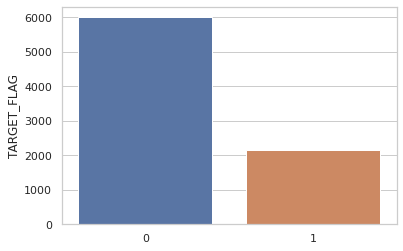

In [3]:
y_value_counts = y.value_counts()
sns.barplot(x=y_value_counts.index, y=y_value_counts)

We clearly observe that we are dealing with an unbalanced dataset.
Roughly speaking, 75% of the data are labelled with the label **0** meaning that no flag has been raised for the clients in question. Hence, special attention should be paid when choosing the metrics for the models. 

### Let's determine the numerical variables and the categorical ones !

In [4]:
X.nunique()

TARGET_AMT    1949
KIDSDRIV         5
AGE             60
HOMEKIDS         6
YOJ             21
INCOME        6612
PARENT1          2
HOME_VAL      5106
MSTATUS          2
SEX              2
EDUCATION        5
JOB              8
TRAVTIME        97
CAR_USE          2
BLUEBOOK      2789
TIF             23
CAR_TYPE         6
RED_CAR          2
OLDCLAIM      2857
CLM_FREQ         6
REVOKED          2
MVR_PTS         13
CAR_AGE         30
URBANICITY       2
dtype: int64

#### First insights:
Based on the number of unique values of each features as well as a quick grasp of the first rows of the dataset, we can start by seperating the features having less than 8 unique variables as potential categorical variables. 

In [5]:
cat_var = [col for col in X.columns if df_train.nunique()[col]<=8]
num_var = [col for col in X.columns if col not in cat_var]

#### Deeper look within categorical variables !

In [6]:
unique_values = {
    col : X[col].value_counts() for col in cat_var
}
for k,v in unique_values.items():
    print(f"\tUnique values for the variable {k} are:\n{v}")
    print("\n")

	Unique values for the variable KIDSDRIV are:
0    7180
1     636
2     279
3      62
4       4
Name: KIDSDRIV, dtype: int64


	Unique values for the variable HOMEKIDS are:
0    5289
2    1118
1     902
3     674
4     164
5      14
Name: HOMEKIDS, dtype: int64


	Unique values for the variable PARENT1 are:
No     7084
Yes    1077
Name: PARENT1, dtype: int64


	Unique values for the variable MSTATUS are:
Yes     4894
z_No    3267
Name: MSTATUS, dtype: int64


	Unique values for the variable SEX are:
z_F    4375
M      3786
Name: SEX, dtype: int64


	Unique values for the variable EDUCATION are:
z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64


	Unique values for the variable JOB are:
z_Blue Collar    1825
Clerical         1271
Professional     1117
Manager           988
Lawyer            835
Student           712
Home Maker        641
Doctor            246
Name: JOB, dtype: int64


	Unique value

We clearly remark that 3 features are falsely considered as categorical variables, namely *KIDSDRIV*, *HOMEKIDS* and *CLM_FREQ*.

In [7]:
vars_to_add_num = ['KIDSDRIV', 'HOMEKIDS', 'CLM_FREQ']
cat_var = [col for col in cat_var if col not in vars_to_add_num]
num_var = [col for col in X.columns if col not in cat_var]
print(f"We have {len(cat_var)} categorical variables and {len(num_var)} numerical variables.")
print(f"\tCategorical variables are:\n{cat_var}")
print(f"\tNumerical variables are:\n{num_var}")

We have 10 categorical variables and 14 numerical variables.
	Categorical variables are:
['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']
	Numerical variables are:
['TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE']


We also remark that some values in the categorical variables are weird (contain "z_" prefix for example). 

Let's clean the data !

In [8]:
# Let's fix weird categories notations
def fix_values(value):

    if value in [np.nan, None]:
        return value
    if value[:2] == "z_":
        return value[2:]
    elif value[0] == "<":
        return value[1:]
    else:
        return value

        
for col in cat_var:
    X[col] = X[col].apply(fix_values)
    df_train[col] = df_train[col].apply(fix_values)    

## Data visualization
### Explore some of the dataset features

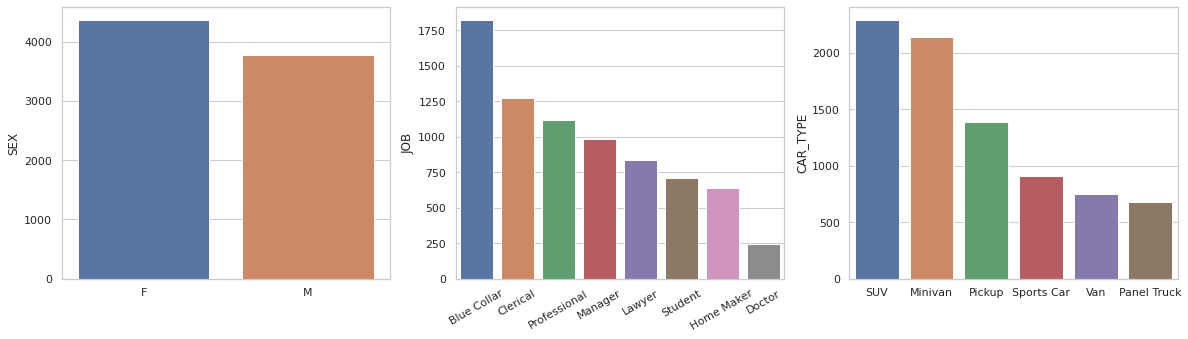

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize= (20,5),ncols=3)
axs[1].tick_params(axis='x', rotation=30)

sns.barplot(
    x=X["SEX"].value_counts().index,
    y=X["SEX"].value_counts(),
    ax=axs[0])

sns.barplot(
    x=X["JOB"].value_counts().index,
    y=X["JOB"].value_counts(),
    ax=axs[1])

sns.barplot(
    x=X["CAR_TYPE"].value_counts().index,
    y=X["CAR_TYPE"].value_counts(),
    ax=axs[2])

We remark that features' categories are not distributed evenly for all of the three categories. The gap is not that significant for the *SEX* feature but when it comes to *JOB* and *CAR_TYPE* features, the gap is really important as the count for some categories may exceed 4 times the count of others.

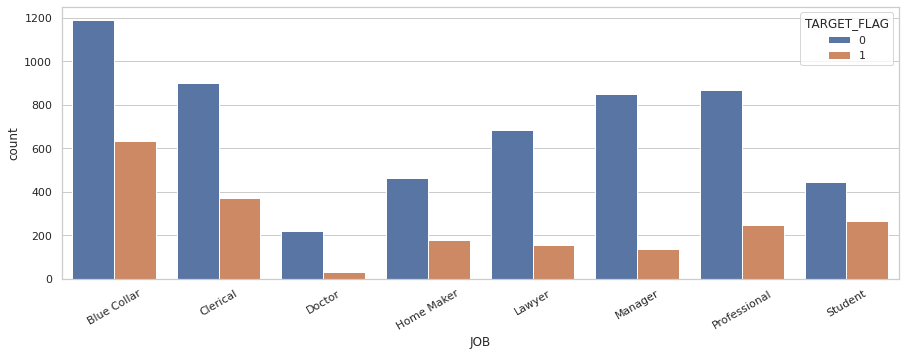

In [10]:
fig, ax = plt.subplots(figsize= (15,5))
ax.tick_params(axis='x', rotation=30)

data = df_train[["TARGET_FLAG", "JOB"]]
data["count"] = 0
data = data.groupby(["JOB", "TARGET_FLAG"])\
    .count()\
    .reset_index()#.rename({'SE':'index1'}, axis = 'columns')

sns.barplot(x="JOB", y="count", hue="TARGET_FLAG", data = data, ax=ax)

Statistically speaking, individuals with manual jobs are much more likely to be flagged than the white collar population.

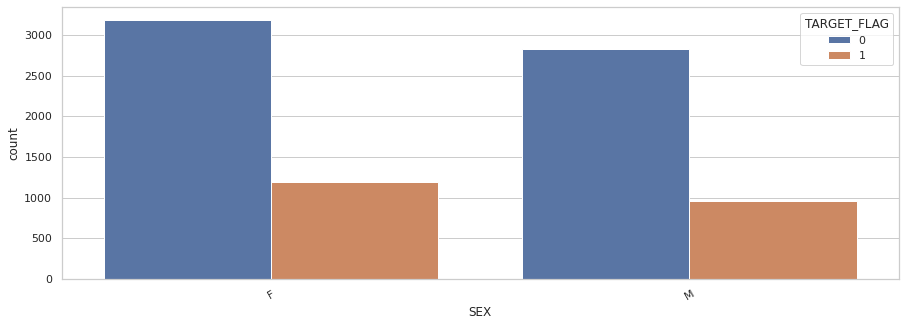

In [11]:
fig, ax = plt.subplots(figsize= (15,5))
ax.tick_params(axis='x', rotation=30)

data = df_train[["TARGET_FLAG", "SEX"]]
data["count"] = 0
data = data.groupby(["SEX", "TARGET_FLAG"])\
    .count()\
    .reset_index()#.rename({'SE':'index1'}, axis = 'columns')

sns.barplot(x="SEX", y="count", hue="TARGET_FLAG", data = data, ax=ax)

We observe that *Male* individuals have slightly higher probabilities of getting flagged.

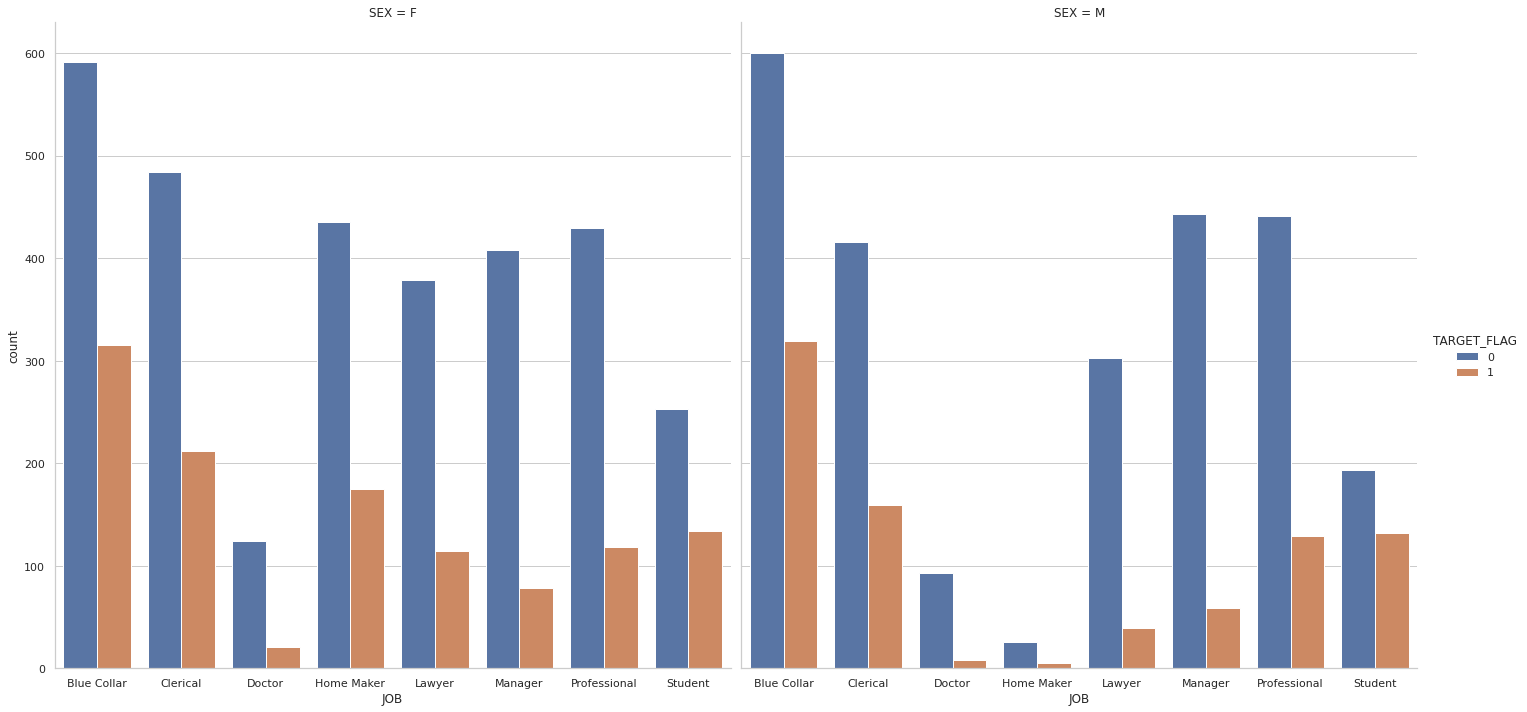

In [12]:
data = df_train[["TARGET_FLAG", "SEX", "JOB"]]
data["count"] = 0
data = data.groupby(["SEX", "TARGET_FLAG", "JOB"])\
    .count()\
    .reset_index()

sns.catplot(x="JOB", y="count", hue="TARGET_FLAG", col="SEX", data = data, kind="bar",
                height=10)

From the above figure we can easily make 2 interpretations:
- There is some equilibrium regarding job distributions among both genders with the exception of the **Home Maker** category where women are much more present.
- Females having white collar jobs are more likely to get flagged compared to their Males counterparts.

## Analysis for numerical data

### clean data from special characters
Columns with money related information are provided with special characters making the pandas.DataFrame kernel interpret it as string. 

Therefore, we need to clean it.

In [13]:
ft_to_clean = ["OLDCLAIM", "HOME_VAL", "INCOME", "BLUEBOOK"]

def clean_ft_money(val):
    try:
        if val == None:
            return np.nan
        if type(val) == float:
            return val
        ch = ""
        for c in val:  
            if c.isalpha() or c.isnumeric() or c == ".":
                ch += c
        return float(ch)
    except:
        print(val, type(val))

for col in ft_to_clean:
    X[col] = X[col].apply(clean_ft_money).astype(float)
    df_train[col] = df_train[col].apply(clean_ft_money).astype(float)

### analyze a sample of numerical features

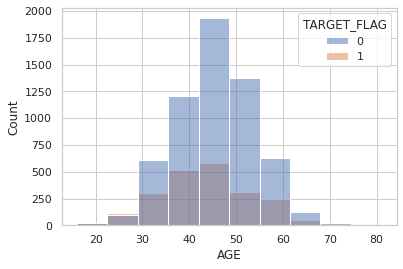

In [14]:
sns.histplot(x="AGE", hue= "TARGET_FLAG", data = df_train, bins=10)

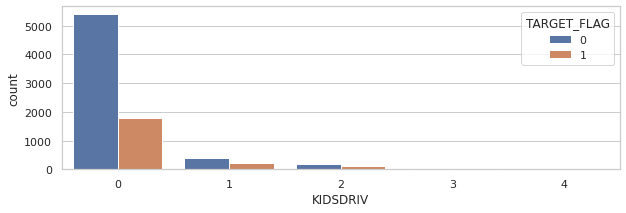

In [15]:
fig, ax = plt.subplots(figsize= (10,3))

data = df_train[["TARGET_FLAG", "KIDSDRIV"]]
data["count"] = 0
data = data.groupby(["KIDSDRIV", "TARGET_FLAG"])\
    .count()\
    .reset_index()#.rename({'SE':'index1'}, axis = 'columns')

sns.barplot(x="KIDSDRIV", y="count", hue="TARGET_FLAG", data = data, ax=ax)

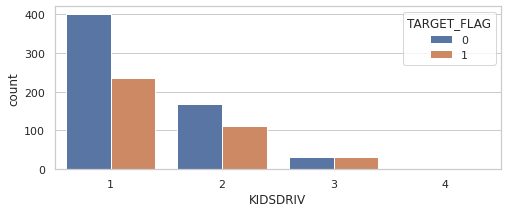

In [16]:
fig, ax = plt.subplots(figsize= (8,3))

data = df_train[["TARGET_FLAG", "KIDSDRIV"]]
data["count"] = 0
data = data.groupby(["KIDSDRIV", "TARGET_FLAG"])\
    .count()\
    .reset_index()#.rename({'SE':'index1'}, axis = 'columns')

sns.barplot(x="KIDSDRIV", y="count", hue="TARGET_FLAG", data = data.loc[data["KIDSDRIV"] > 0], ax=ax)

#### Interpretations
- The probability of being flagged is much higher among population under 20's and over 60's
- The probability of being flagged is an increasing function of variable *KIDSDRIV* which most like refers the number of kids that are driving the vehicules with the parent.

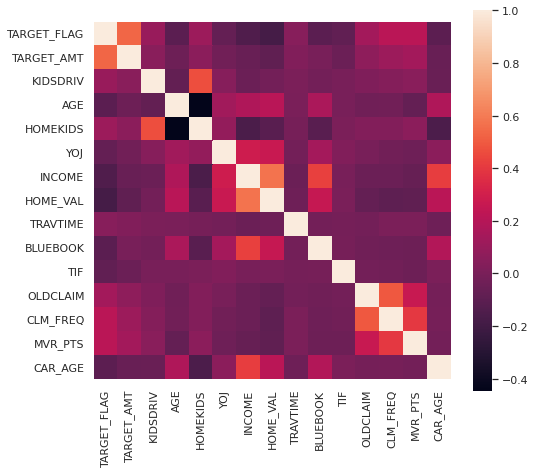

In [17]:
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(corr, square=True)

In [18]:
corr.loc[[idx for idx in corr.index if idx != "TARGET_FLAG"],["TARGET_FLAG"]]\
    .abs().style\
    .highlight_max(color="lightblue")\
    .highlight_min(color="lightgreen")

,TARGET_FLAG
TARGET_AMT,0.534246
KIDSDRIV,0.103668
AGE,0.103217
HOMEKIDS,0.115621
YOJ,0.070512
INCOME,0.142008
HOME_VAL,0.183737
TRAVTIME,0.048368
BLUEBOOK,0.103383
TIF,0.082370


#### Interpretation:
- Almost all features are correlated with the target variable *TARGET_FLAG* with a correlation coefficient between **0,08 and 0,22** (in absolute value) which means that we can extract significant information from them. 
- Only the category *TRAVTIME* has an absolute correlation coefficient under 0,05. As it is really slightly under the before mentionned variable, we will keep it.
- The feature *TARGET_AMT* is highly correlated with the target variable with a correlation coefficient of **0.53**. Therefore, we will exclude it otherwise the machine learning task will be trivial.

In [19]:
X.drop(columns = "TARGET_AMT", inplace=True)
df_train.drop(columns = "TARGET_AMT", inplace=True)
num_var.remove("TARGET_AMT")

## Checking for missing values

In [20]:
pd.DataFrame(
    data = X.isna().sum() / len(X) * 100,
    columns = ["m_v_pct"]).style\
    .format("{:.2f}%")\
    .apply(lambda x:["color: green" if x["m_v_pct"] <20 else '' for _ in x], axis=1)\
    .apply(lambda x:["color: red" if x["m_v_pct"] >=20 else '' for _ in x], axis=1)\
    .apply(lambda x:["font-weight: bold" if x["m_v_pct"] >0 else '' for _ in x], axis=1)\

,m_v_pct
KIDSDRIV,0.00%
AGE,0.07%
HOMEKIDS,0.00%
YOJ,5.56%
INCOME,5.45%
PARENT1,0.00%
HOME_VAL,5.69%
MSTATUS,0.00%
SEX,0.00%
EDUCATION,0.00%


#### Interpretation:
- All features have ratios of missing values under 10%. Hence, there is no particular problem on this specific point and no feature should be removed for lack of enough non-missing values.

# Machine learning

## Baseline model

In [21]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3)

num_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_var),
        ('cat', cat_transformer, cat_var)])

clf_1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier()),
    ])

clf_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['KIDSDRIV', 'AGE',
                                                   'HOMEKIDS', 'YOJ', 'INCOME',
                                                   'HOME_VAL', 'TRAVTIME',
                                                   'BLUEBOOK', 'TIF',
                                                   'OLDCLAIM', 'CLM_FREQ',
                                                   'MVR_PTS', 'CAR_AGE']),
                                                 ('cat',
                                                  Pipeline(step

In [22]:
preds = clf_1.predict(X_test)
print(f"balanced_accuracy_score: {round(f1_score(preds, y_test),3)}")
print(f"balanced_accuracy_score: {round(balanced_accuracy_score(preds, y_test)*100,2)}%")
print(f"accuracy_score: {round(accuracy_score(preds, y_test)*100,2)}%")

balanced_accuracy_score: 0.482
balanced_accuracy_score: 73.96%
accuracy_score: 78.44%


In [23]:
enc_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(cat_var)
labels = np.concatenate([num_var, enc_cat_features])
ft_imp = pd.DataFrame(
    data = {
        "ft_name" : labels,
        "ft_importance" :clf_1.get_params()['classifier'].feature_importances_,
    }).sort_values(by="ft_importance", ascending=False)

ft_imp.head()

,ft_name,ft_importance
7,BLUEBOOK,0.080234
4,INCOME,0.079244
6,TRAVTIME,0.070437
1,AGE,0.068270
5,HOME_VAL,0.067871


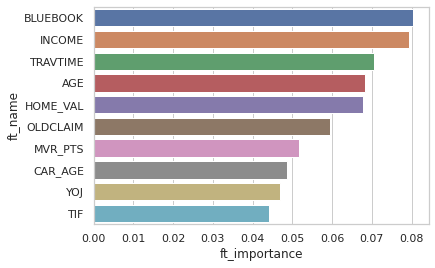

In [24]:
sns.barplot(y="ft_name", x="ft_importance", data = ft_imp.iloc[:10,:], orient = "h")

## Let's try to improve the results !
Use flaml library to get perform model selection and hyperparameter tuning

In [25]:
automl = AutoML()

# Specify automl goal and constraint
y_train_v_c = y_train.value_counts()
fit_settings = {
    "automl_model__time_budget": 600,  # in seconds
    "automl_model__metric": 'f1',
    "automl_model__task": 'classification',
    # "automl_model__sample_weight" : y_train.apply(lambda val:1/y_train_v_c[val]).values,
    "automl_model__eval_method" : "cv"
}

# Train with labeled input data
clf_2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('automl_model', automl),])

clf_2.fit(X_train, y_train, **fit_settings)

[flaml.automl: 09-29 01:16:40] {1432} INFO - Evaluation method: cv
[flaml.automl: 09-29 01:16:40] {1478} INFO - Minimizing error metric: 1-f1
[flaml.automl: 09-29 01:16:40] {1515} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 09-29 01:16:40] {1748} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-29 01:16:41] {1866} INFO - Estimated sufficient time budget=1732s. Estimated necessary time budget=31s.
[flaml.automl: 09-29 01:16:41] {1944} INFO -  at 0.2s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl: 09-29 01:16:41] {1748} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-29 01:16:41] {1944} INFO -  at 0.4s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl: 09-29 01:16:41] {1748} INFO - iteration 2, current learner lgbm
[flaml.automl: 09-29 01:16:41] {1944} INFO -  at 0.5s,	estimator lgbm's best error=1.0000,	best e

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['KIDSDRIV', 'AGE',
                                                   'HOMEKIDS', 'YOJ', 'INCOME',
                                                   'HOME_VAL', 'TRAVTIME',
                                                   'BLUEBOOK', 'TIF',
                                                   'OLDCLAIM', 'CLM_FREQ',
                                                   'MVR_PTS', 'CAR_AGE']),
                                                 ('cat',
                                                  Pipeline(step

In [26]:
preds = clf_2.predict(X_test)
print(f"balanced_accuracy_score: {round(f1_score(preds, y_test),3)}")
print(f"balanced_accuracy_score: {round(balanced_accuracy_score(preds, y_test)*100,2)}%")
print(f"accuracy_score: {round(accuracy_score(preds, y_test)*100,2)}%")

balanced_accuracy_score: 0.526
balanced_accuracy_score: 72.71%
accuracy_score: 78.36%


### Interpretations
- Running the model selection and hyperparameters fine-tuning process did not hugely improve the performance of the model. On the other hand, we managed to improve the **f1-score** metric which seems to be the most adequate metric in this situation.
- The fact that we could significantly improve the performance of the ML models is most likely due to the fact that using Cross-validation strategy is strengthening our model in terms of low variance and therefore the bias couldn't be really minimized.
- We should also pay attention that the data itself impose some kind of performance barrier as no data is completely free of noise and mislabelling.
- The presence of missing data has also complicated the task of getting really performing model.

# Predictions for the test set

In [27]:
df_test = pd.read_csv("test_auto.csv", index_col = "INDEX").drop(columns = ["TARGET_FLAG", "TARGET_AMT"])
df_test

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,
3,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
9,1,40.0,1,11.0,"$50,815",Yes,$0,z_No,M,z_High School,Manager,21,Private,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
10,0,44.0,2,12.0,"$43,486",Yes,$0,z_No,z_F,z_High School,z_Blue Collar,30,Commercial,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
18,0,35.0,2,NaN,"$21,204",Yes,$0,z_No,M,z_High School,Clerical,74,Private,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
21,0,59.0,0,12.0,"$87,460",No,$0,z_No,M,z_High School,Manager,45,Private,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10279,0,46.0,0,0.0,$0,No,$0,Yes,z_F,z_High School,Student,32,Commercial,"$1,500",6,Sports Car,no,"$20,519",1,Yes,3,8.0,z_Highly Rural/ Rural
10281,0,46.0,0,12.0,"$43,501",No,"$134,977",Yes,M,z_High School,Professional,60,Private,"$16,080",3,Minivan,no,$0,0,No,2,1.0,z_Highly Rural/ Rural
10285,0,55.0,0,10.0,"$141,083",No,"$393,624",Yes,z_F,Masters,Lawyer,42,Private,"$21,110",10,Sports Car,no,$0,0,No,0,22.0,z_Highly Rural/ Rural


In [28]:
for col in ft_to_clean:
    df_test[col] = df_test[col].apply(clean_ft_money).astype(float)
        
for col in cat_var:
    df_test[col] = df_test[col].apply(fix_values)

In [30]:
df_test["TARGET_FLAG"] = clf_2.predict(df_test)
df_test.to_csv("test_auto_Houssem_GUIDARA.csv")

# Conclusion
Within this small project, we dealed with an unbalanced binary classification problem.

We started by analyzing the data through which we found solid evidence that some features are correlated to the target variable such as *AGE*, *JOB*, *INCOME*.

Debatably surprising, most of the highly correlated features to the target variable are *driver-related* features meaning that they only concern the owner of the car and not in any way the car itself.
For example, who could believe that the feature *CAR_AGE* is only the *9th* most important feature.

Through the machine learning section, we explored 2 models the first is more or less a baseline model with no hyperparameters fine-tuning which gave as a **f1-score = 0.482**.

Thanks to the *flaml* library, we could improve the performance having a **f1-score = 0.526**.

As a future research areas, we could investigate some feature selection techniques and try different combinations of missing values handling which could even more improve the overall performance.

Needless to say, the choice of metric is crucial and all the analysis depends on it. As for me, I made the choice to go with the *f1-score* as it involves both *precision* and *recall* metrics. However, more advanced metrics could give different insights and are worth exploring such as *Area Under the Curve (AUC)* and *log_loss*.